In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Исходная папка с данными
data_dir = r"C:\Users\Omen\Desktop\Chest_X_Ray_Dataset"
output_dir = r"C:\Users\Omen\Desktop\Split_Chest_X_Ray_Dataset"

# Доли для разделения
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Создаем директории для разделенных данных
for split in ['train', 'val', 'test']:
    for category in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Разделение данных
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)

    # Разделяем данные
    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Копируем файлы
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'train', category))
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'val', category))
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'test', category))

print("Данные успешно разделены!")


Данные успешно разделены!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Трансформации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к разделенным данным
data_dir = output_dir
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# Даталоадеры
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt


# Функция для построения графиков точности и потерь
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # График потерь
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')


    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')


    plt.tight_layout()
    plt.show()

# Функция для построения матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

# Функция для построения распределения классов
def plot_class_distribution(y_true, y_pred, classes):
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_true, bins=np.arange(len(classes) + 1) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
    plt.xticks(range(len(classes)), classes)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('True Class Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(y_pred, bins=np.arange(len(classes) + 1) - 0.5, rwidth=0.8, color='red', alpha=0.7)
    plt.xticks(range(len(classes)), classes)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Predicted Class Distribution')

    plt.tight_layout()
    plt.show()


In [5]:
class ChestXRayModel(nn.Module):
    def __init__(self, num_classes=4):
        super(ChestXRayModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ChestXRayModel(num_classes=4).to(device)

C:\Users\Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        # Обучение
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Вычисляем точность на тренировочном наборе
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Валидация
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Вычисляем точность на валидационном наборе
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Построение графиков
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Epoch 1/10, Train Loss: 0.2543, Train Accuracy: 0.9120, Val Loss: 0.1095, Val Accuracy: 0.9614
Epoch 2/10, Train Loss: 0.1413, Train Accuracy: 0.9517, Val Loss: 0.1874, Val Accuracy: 0.9340
Epoch 3/10, Train Loss: 0.1139, Train Accuracy: 0.9597, Val Loss: 0.1600, Val Accuracy: 0.9474
Epoch 4/10, Train Loss: 0.0896, Train Accuracy: 0.9709, Val Loss: 0.1194, Val Accuracy: 0.9565
Epoch 5/10, Train Loss: 0.0786, Train Accuracy: 0.9721, Val Loss: 0.1549, Val Accuracy: 0.9439
Epoch 6/10, Train Loss: 0.0758, Train Accuracy: 0.9715, Val Loss: 0.3778, Val Accuracy: 0.8730
Epoch 7/10, Train Loss: 0.0663, Train Accuracy: 0.9772, Val Loss: 0.0779, Val Accuracy: 0.9670
Epoch 8/10, Train Loss: 0.0507, Train Accuracy: 0.9822, Val Loss: 0.2774, Val Accuracy: 0.9221
Epoch 9/10, Train Loss: 0.0434, Train Accuracy: 0.9850, Val Loss: 0.1100, Val Accuracy: 0.9656
Epoch 10/10, Train Loss: 0.0320, Train Accuracy: 0.9878, Val Loss: 0.2450, Val Accuracy: 0.9263


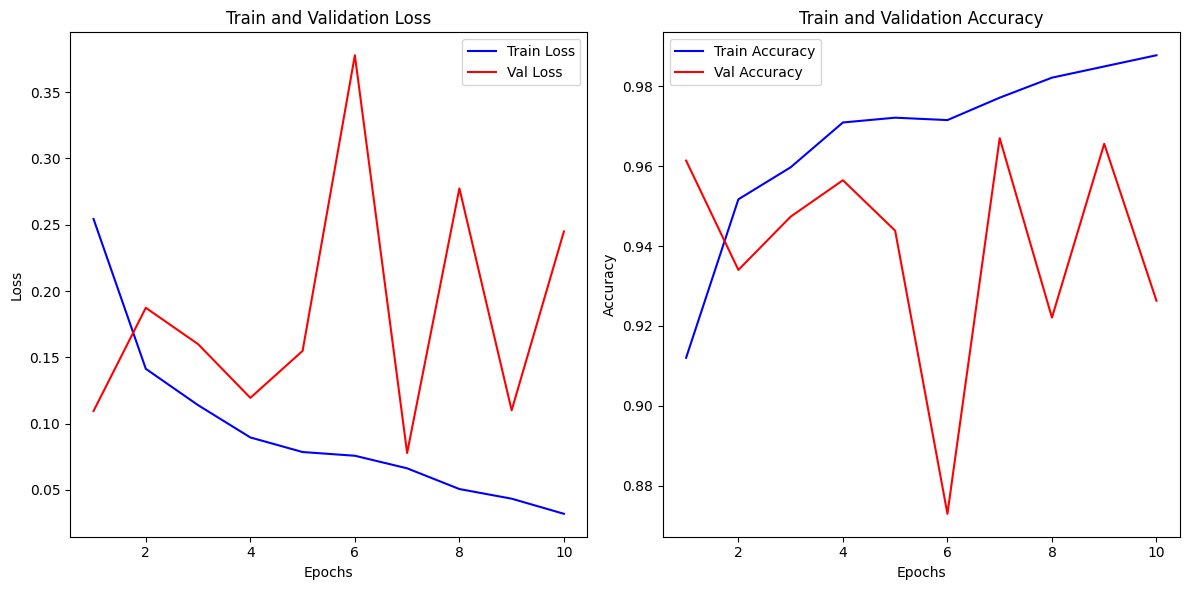

In [7]:
# Гиперпараметры
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10


train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device)
model_save_path = 'X_Ray_Classification.pth'
torch.save(model.state_dict(), model_save_path)

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Сохраняем предсказания для отчета
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Вычисляем точность
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_data.classes))

    # Построение матрицы ошибок и распределения классов
    plot_confusion_matrix(y_true, y_pred, classes=['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'])
    plot_class_distribution(y_true, y_pred, classes=['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'])




Test Accuracy: 0.9316

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.70      0.98      0.81        58
       NORMAL       0.99      0.85      0.91       159
    PNEUMONIA       0.95      0.96      0.96       428
TURBERCULOSIS       0.97      0.92      0.94        71

     accuracy                           0.93       716
    macro avg       0.90      0.93      0.91       716
 weighted avg       0.94      0.93      0.93       716



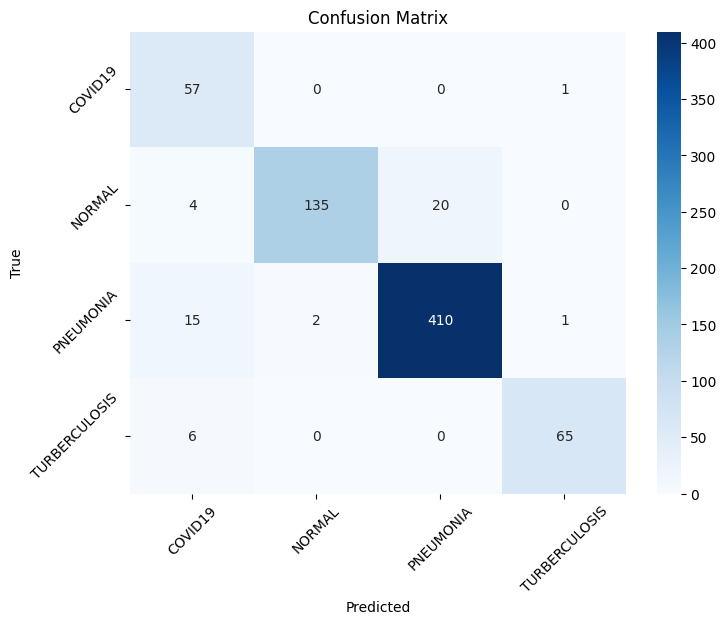

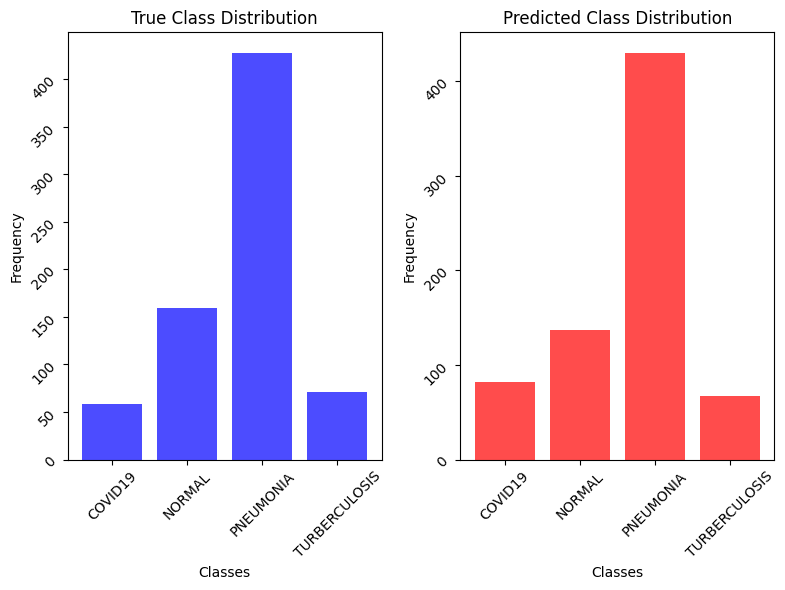

In [9]:
evaluate_model(model, test_loader)

In [10]:
from PIL import Image
import torch
from torchvision import transforms

# Загружаем модель
model = ChestXRayModel(num_classes=4).to(device)
model.load_state_dict(torch.load('X_Ray_Classification.pth')) 
model.eval()  # Устанавливаем модель в режим оценки

# Преобразования, которые использовались при обучении
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка и преобразование изображения
img_path = r"C:\Users\Omen\Desktop\Split_Chest_X_Ray_Dataset\test\TURBERCULOSIS\Tuberculosis-29.png"  
image = Image.open(img_path).convert("RGB")  # Открываем изображение

# Применяем те же трансформации, что и для данных обучения
image_tensor = transform(image).unsqueeze(0).to(device)  # Добавляем размерность для батча

# Получаем предсказание
with torch.no_grad():  # Отключаем градиенты для предсказания
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)

# Индекс предсказанного класса
predicted_class = predicted.item()

# Сопоставляем индекс с классом
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
predicted_label = classes[predicted_class]

print(f"Предсказанный класс для изображения: {predicted_label}")


C:\Users\Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Omen\AppData\Local\Temp\ipykernel_12416\3888521127.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling

Предсказанный класс для изображения: TURBERCULOSIS
